### LICENSE PLATE OBJECT DETECTION

Based on https://huggingface.co/datasets/keremberke/license-plate-object-detection

In [1]:
# Install dependencies and libreries
#!pip install torchmetrics
#!pip install --upgrade --no-cache-dir gdown
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
#pip install torchsummary

In [3]:
#!pip install datasets

In [4]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoFeatureExtractor
from datasets import load_dataset
from PIL import Image, ImageDraw
#import torchvision.transforms as transform

# Dataloader
from torch.utils.data import DataLoader

# For data augmentation
import albumentations as A
import cv2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
torch.backends.cudnn.benchmark = True

In [7]:

data_set = load_dataset("keremberke/license-plate-object-detection", name="full")
data_set

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6176
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1765
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 882
    })
})

### Characteristics of dataset

In [8]:
data_set.shape

{'train': (6176, 5), 'validation': (1765, 5), 'test': (882, 5)}

In [9]:
data_set.num_columns

{'train': 5, 'validation': 5, 'test': 5}

In [10]:
data_set.column_names

{'train': ['image_id', 'image', 'width', 'height', 'objects'],
 'validation': ['image_id', 'image', 'width', 'height', 'objects'],
 'test': ['image_id', 'image', 'width', 'height', 'objects']}

In [11]:
def building_dataset(dataset):
    for ds_name in dataset:
        if ds_name == 'train':
            img_id_train = dataset[ds_name][::]['image_id']
            img_train = dataset[ds_name][::]['image']
            objects_train = dataset[ds_name][::]['objects']
        elif  ds_name == 'test':
            img_id_test = dataset[ds_name][::]['image_id']
            img_test = dataset[ds_name][::]['image']
            objects_test = dataset[ds_name][::]['objects']
        else:
            img_id_validation = dataset[ds_name][::]['image_id']
            img_validation = dataset[ds_name][::]['image']
            objects_validation = dataset[ds_name][::]['objects']

    return img_train, img_test, img_validation, objects_train, objects_test, objects_validation, img_id_train, img_id_test, img_id_validation

In [12]:
img_train, img_test, img_validation, obj_train, obj_test, obj_validation, img_id_train, img_id_test, img_id_validation= building_dataset(data_set)

In [13]:
img_test

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x298>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=490x307>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.Jpeg

In [14]:
def draw_bounding_box(images, objects):
    list_images_bb = []
    list_bb = []
    lst_categories = []
    for img, obj in tqdm(zip(images, objects), total=len(images), desc=f' Processing images'):
        if len(obj['id']) == 1:
            draw = ImageDraw.Draw(img)
            bounding_box = obj['bbox'][0]
            x, y, w, h = map(int, obj['bbox'][0])
            draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
            obj['category'][0] = 'patente'
            categories = obj['category'][0]
            list_images_bb.append(img)
            list_bb.append(bounding_box)
            lst_categories.append(categories)
    return list_images_bb, list_bb, lst_categories

In [15]:
from tqdm.notebook import tqdm

image_lst_train, lst_bb_train,  lst_label_train = draw_bounding_box(img_train, obj_train)

 Processing images:   0%|          | 0/6176 [00:00<?, ?it/s]

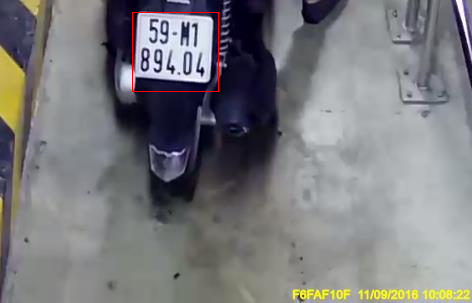

In [16]:
image_lst_train[1000]

In [17]:
image_lst_test, lst_bb_test, label_lst_test = draw_bounding_box(img_test, obj_test)

 Processing images:   0%|          | 0/882 [00:00<?, ?it/s]

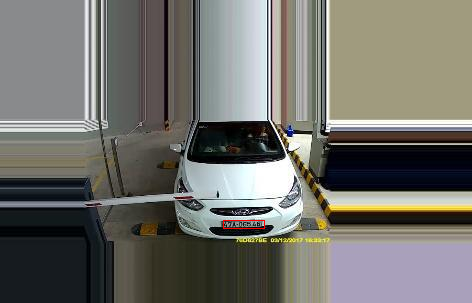

In [18]:
image_lst_test[700]

In [19]:
image_lst_validation, lst_bb_validation, label_lst_validation = draw_bounding_box(img_validation, obj_validation)

 Processing images:   0%|          | 0/1765 [00:00<?, ?it/s]

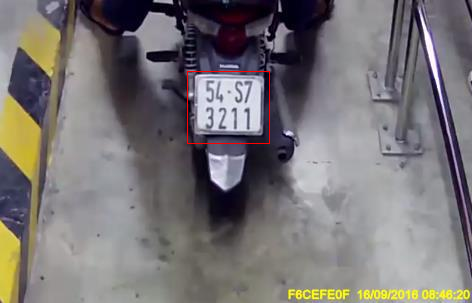

In [20]:
image_lst_validation[75]

### Preprocessing data

In [21]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [22]:
# Transform data with data augmentation

from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=15,p=0.5),
    A.Perspective(scale=[0,0.1],keep_size=False,fit_output=False,p=1),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5, 0.5, 0.5],std=[0.225, 0.225, 0.225]),
    ToTensorV2
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))

In [23]:
lst_bb_test_int = [list(map(int, bbox_int)) for bbox_int in lst_bb_test]


In [24]:
lst_bb_prueba = [x + ['patente'] for x in lst_bb_test_int]

In [25]:
#for image, bounding_box, class_label in zip(image_lst_test, lst_bb_test, class_labels):
#    image = np.array(image.convert("RGB"))[:, :, ::-1]
#    transformed = transform(image=image, bboxes = bounding_box, class_labels = class_labels)

In [26]:
#def formated_annotations(lst_img_id, lst_bounding_box):
#    lst_annotations = []
#    for  img_id, bounding_box in zip(lst_img_id, lst_bounding_box):
#        new_annot = {
#            "image_id" : img_id,
#            "bbox" : bounding_box
#        }
#        lst_annotations.append(new_annot)
#    return lst_annotations

In [27]:
#Transforming batch
#def transforn_aug_ann(lst_img, lst_img_ids, lst_formatted_anns):
#    images, bboxes, = [], []
#    for image, object in zip(lst_img, lst_formatted_anns):
#        image = np.array(image.convert("RGB"))[:, :, ::-1]
#        out = transform(image = image, bboxes = object['bbox'] )
#        images.append(out["image"])
#        bboxes.append(out["bboxes"])
#    targets = [

#        {"image_id": id_, "annotations": lst_formatted_anns(id_, box_)}

#        for id_, box_ in zip(lst_img_ids, bboxes)
#    ]

#    return image_processor(images=images, annotations=targets, return_tensors="pt")


### RetinaNet

In [28]:
#Taken from https://stackoverflow.com/questions/64574142/how-to-load-a-dataset-starting-from-list-of-images-pytorch
#https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data
from torchvision import transforms as tt
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, bb_list, label_lst):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.bb_list = bb_list
        self.label_lst = label_lst

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        transform = tt.Compose([
            tt.ToTensor()
        ])
        image = transform(img)

        bboxes_list = self.bb_list[idx]
        bboxes = torch.as_tensor(bboxes_list, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor([1])

        target = {
            "boxes": bboxes,
            "labels": label
        }

        return image, target


In [29]:
dataset_train = MyDataset(image_lst_train, lst_bb_train, lst_label_train)

In [30]:
dataset_test = MyDataset(image_lst_test, lst_bb_test, label_lst_test)

In [31]:
dataset_validation = MyDataset(image_lst_validation, lst_bb_validation, label_lst_validation)

In [32]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [34]:
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, collate_fn=collate_fn, shuffle=False)

In [35]:
test_data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=4, collate_fn=collate_fn, shuffle=False)

In [36]:
validation_dataloader = torch.utils.data.DataLoader(dataset_validation, batch_size=4, collate_fn=collate_fn, shuffle=False)

In [37]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 2, pretrained=False, pretrained_backbone = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
#Based on https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch4-RetinaNet.html

import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30
retina.to(device)

# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# about 4 min per epoch on Colab GPU

for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)


        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        epsilon = 1e-5
        for target in targets:
            boxes = target["boxes"]
            for i, box in enumerate(boxes):
                # Si x_max < x_min o y_max < y_min
                if box[2] <= box[0] or box[3] <= box[1]:
                    box[0], box[2] = min(box[0], box[2]), max(box[0], box[2]) + epsilon
                    box[1], box[3] = min(box[1], box[3]), max(box[1], box[3]) + epsilon
                    target["boxes"][i] = box

        loss_dict = retina(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        with torch.no_grad():
            retina.eval()
            outputs = retina(images)
            retina.train()
            for output, target in zip(outputs, targets):
                pred_labels = output['labels'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                correct_predictions += (pred_labels == true_labels).sum()
                total_predictions += len(true_labels)

        i += 1
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses

    epoch_accuracy = correct_predictions / total_predictions  # calcular precisión de la época
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {time.time() - start:.2f}s")


  0%|          | 0/1503 [00:00<?, ?it/s]

In [ ]:
print(bboxes[:5])
